In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
from transformers import BertTokenizer, BertModel

import numpy as np
import pandas as pd
import random
import time
import os
import argparse
from collections import defaultdict
from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import json

2026-02-21 20:06:23.877846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771704384.182038      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771704384.274461      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771704385.067927      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771704385.067971      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771704385.067974      24 computation_placer.cc:177] computation placer alr

In [2]:
def main(args):
    torch.manual_seed(args.seed)
    torch.cuda.empty_cache()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


    file_map = {
            "gab": '/kaggle/input/datasets/jonniellampano/test-set/Mistral_Rationales_file_GAB_dataset(90-10).csv',
            "twitter": '/kaggle/input/datasets/jonniellampano/final-data/Mistral_Rationales_file_Twitter_dataset(85-15).csv',
            "reddit": '/kaggle/input/datasets/jonniellampano/final-data/Mistral_Rationales_file_REDDIT_dataset(85-15).csv',
            "youtube": '/kaggle/input/datasets/jonniellampano/final-data/Mistral_Rationales_file_YOUTUBE_dataset(85-15).csv',
            "implicit": '/kaggle/input/datasets/jonniellampano/final-data/Mistral_Rationales_file_IMPLICIT_dataset(85-15).csv'
        }

    file_path = file_map[args.dataset]
    df = pd.read_csv(file_path)
    train_df = df[df['exp_split'] == 'train']
    test_df = df[df['exp_split'] == 'test']

    print("Train df: ", len(train_df))
    print("Test_df: ", len(test_df))

    import gc
    gc.collect()

    bert_model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
    tokenizer_bert = AutoTokenizer.from_pretrained(bert_model_name)

    class AdditionalCustomDataset(Dataset):
        def __init__(self, texts, labels, additional_texts, tokenizer, bert_tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.additional_texts = additional_texts
            self.tokenizer = tokenizer
            self.bert_tokenizer = bert_tokenizer
            self.max_length = max_length

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            texts = self.texts[idx]
            additional_texts = self.additional_texts[idx]
            labels = self.labels[idx]
            encoding = self.tokenizer(texts, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
            additional_encoding = self.bert_tokenizer(additional_texts, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
            original_input_ids = encoding['input_ids'].squeeze()
            additional_input_ids = additional_encoding['input_ids'].squeeze()
            original_attention_mask = encoding['attention_mask'].squeeze()
            additional_attention_mask = additional_encoding['attention_mask'].squeeze()
            labels = labels
            return original_input_ids, original_attention_mask, additional_input_ids, additional_attention_mask, labels

    train_idx, val_idx = train_test_split(
        train_df.index,
        test_size=0.2,
        stratify=train_df["label"],
        random_state=args.seed
    )
    
    if args.dataset == "implicit":
        train_text = train_df.loc[train_idx, "post"].tolist()
        val_texts  = train_df.loc[val_idx, "post"].tolist()
    else:
        train_text = train_df.loc[train_idx, "text"].tolist()
        val_texts  = train_df.loc[val_idx, "text"].tolist()
    
    add_train_text = train_df.loc[train_idx, "Mistral_Rationales"].tolist()
    add_val_texts  = train_df.loc[val_idx, "Mistral_Rationales"].tolist()
    
    train_labels = train_df.loc[train_idx, "label"].tolist()
    val_labels   = train_df.loc[val_idx, "label"].tolist()

    train_dataset = AdditionalCustomDataset(
        train_text,
        train_labels,
        add_train_text,
        tokenizer,
        tokenizer_bert,
        max_length=512
    )
    
    val_dataset = AdditionalCustomDataset(
        val_texts,
        val_labels,
        add_val_texts,
        tokenizer,
        tokenizer_bert,
        max_length=512
    )

    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    class ProjectionMLP(nn.Module):
        def __init__(self, input_size, output_size):
            super(ProjectionMLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(),
                nn.Linear(output_size, 2)
            )

        def forward(self, x):
            return self.layers(x)

    class GumbelTokenSelector(nn.Module):
        def __init__(self, hidden_size, tau=1.0):
            super().__init__()
            self.tau = tau
            self.proj = nn.Linear(hidden_size * 2, 1)
    
        def forward(self, token_embeddings, cls_embedding, training=True):
            B, L, H = token_embeddings.size()
            cls_exp = cls_embedding.unsqueeze(1).expand(-1, L, -1)
            x = torch.cat([token_embeddings, cls_exp], dim=-1)
            logits = self.proj(x).squeeze(-1)
    
            if training:
                probs = F.gumbel_softmax(
                    torch.stack([logits, torch.zeros_like(logits)], dim=-1),
                    tau=self.tau,
                    hard=False
                )[..., 0]
            else:
                probs = torch.sigmoid(logits)
            return probs, logits

    class MultiScaleAttentionCNN(nn.Module):
        def __init__(self, hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4), dropout=0.3):
            super().__init__()
            self.convs = nn.ModuleList([
                nn.Conv1d(hidden_size, num_filters, k) for k in kernel_sizes
            ])
            self.attention_fc = nn.Linear(num_filters, 1)
            self.dropout = nn.Dropout(dropout)
            self.out_dim = num_filters * len(kernel_sizes)
    
        def forward(self, x, mask):
            x = x.transpose(1, 2)
            feats = []
            for conv in self.convs:
                h = F.relu(conv(x))
                h = h.transpose(1, 2)
                attn = self.attention_fc(h).squeeze(-1)
                attn = attn.masked_fill(mask[:, :attn.size(1)] == 0, -1e9)
                alpha = F.softmax(attn, dim=1)
                pooled = torch.sum(h * alpha.unsqueeze(-1), dim=1)
                feats.append(pooled)
            out = torch.cat(feats, dim=1)
            return self.dropout(out)

    class TemporalCNN(nn.Module):
        def __init__(self, hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4), dropout=0.1, dilation_base=2):
            super().__init__()
            self.kernel_sizes = kernel_sizes
            self.dilation_base = dilation_base
            self.convs = nn.ModuleList([
                nn.Conv1d(hidden_size, num_filters, k, dilation=dilation_base ** i, padding=0)
                for i, k in enumerate(kernel_sizes)
            ])
            self.dropout = nn.Dropout(dropout)
            self.out_dim = num_filters * len(kernel_sizes)
    
        def _causal_padding(self, x, kernel_size, dilation):
            padding = (kernel_size - 1) * dilation
            return F.pad(x, (padding, 0))
    
        def forward(self, x, attention_mask):
            mask = attention_mask.unsqueeze(-1)
            x = x * mask
            x = x.transpose(1, 2)
            feats = []
            for i, conv in enumerate(self.convs):
                kernel_size = self.kernel_sizes[i]
                dilation = self.dilation_base ** i
                x_padded = self._causal_padding(x, kernel_size, dilation)
                c = F.relu(conv(x_padded))
                p = F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2)
                feats.append(p)
            out = torch.cat(feats, dim=1)
            return self.dropout(out)

    class ConcatModel(nn.Module):
        def __init__(self, hatebert_model, additional_model, temporal_cnn, msa_cnn, selector, projection_mlp, freeze_additional_model=True, freeze_hatebert=True):
            super().__init__()
            self.hatebert_model = hatebert_model
            self.additional_model = additional_model
            self.temporal_cnn = temporal_cnn
            self.msa_cnn = msa_cnn
            self.selector = selector
            self.projection_mlp = projection_mlp
    
            if freeze_additional_model:
                for p in self.additional_model.parameters():
                    p.requires_grad = False
            if freeze_hatebert:
                for p in self.hatebert_model.parameters():
                    p.requires_grad = False

        def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask):
            hate_outputs = self.hatebert_model(input_ids=input_ids, attention_mask=attention_mask)
            seq_emb = hate_outputs.last_hidden_state
            cls_emb = seq_emb[:, 0, :]
            
            token_probs, token_logits = self.selector(seq_emb, cls_emb, self.training)
            temporal_feat = self.temporal_cnn(seq_emb, attention_mask)
            
            weights = token_probs.unsqueeze(-1)
            H_r = (seq_emb * weights).sum(dim=1) / (weights.sum(dim=1) + 1e-6)
            
            with torch.no_grad():
                add_outputs = self.additional_model(input_ids=additional_input_ids, attention_mask=additional_attention_mask)
                add_seq = add_outputs.last_hidden_state
            
            msa_feat = self.msa_cnn(add_seq, additional_attention_mask)
            concat = torch.cat([cls_emb, temporal_feat, msa_feat, H_r], dim=1)
            logits = self.projection_mlp(concat)
            return logits

    hatebert_model = BertModel.from_pretrained("GroNLP/HateBERT").to(device)
    additional_model = BertModel.from_pretrained("bert-base-uncased").to(device)
    temporal_cnn = TemporalCNN(hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4)).to(device)
    msa_cnn = MultiScaleAttentionCNN(hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4)).to(device)
    selector = GumbelTokenSelector(hidden_size=768, tau=1.0).to(device)
    projection_mlp = ProjectionMLP(input_size=temporal_cnn.out_dim + msa_cnn.out_dim + 768 * 2, output_size=512).to(device)

    freeze_flag = args.freeze.lower() if args.freeze else 'yes'
    
    if freeze_flag == 'yes':
        concat_model = ConcatModel(hatebert_model=hatebert_model, additional_model=additional_model, temporal_cnn=temporal_cnn, msa_cnn=msa_cnn, selector=selector, projection_mlp=projection_mlp, freeze_additional_model=True, freeze_hatebert=True).to(device)
    elif freeze_flag == 'no':
        concat_model = ConcatModel(hatebert_model=hatebert_model, additional_model=additional_model, temporal_cnn=temporal_cnn, msa_cnn=msa_cnn, selector=selector, projection_mlp=projection_mlp, freeze_additional_model=True, freeze_hatebert=False).to(device)
    else:
        raise ValueError(f"Invalid freeze option: {args.freeze}. Must be 'yes' or 'no'.")

    concat_model = concat_model.to(device)

    optimizer = AdamW(concat_model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss().to(device)

    from tqdm import tqdm
    os.makedirs("/kaggle/working/models", exist_ok=True)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "epoch_time": [],
        "train_throughput": [],
        "val_confidence_mean": [],
        "val_confidence_std": [],
        "gpu_memory_mb": [],
        "val_loss": [],
    }
    
    all_epoch_val_confidences = []

    # ================= EARLY STOPPING CONFIG (BASED ON LOSS) =================
    early_stop_patience = args.patience if hasattr(args, "patience") else 3
    early_stop_counter = 0
    best_val_loss = float("inf")  # Changed from best_val_f1
    best_epoch = -1
    best_val_f1 = 0.0
    
    best_model_path = (
        f"/kaggle/working/models/"
        f"best_concat_model_{args.dataset}_seed{args.seed}.pth"
    )


    for epoch in range(args.num_epochs):
        epoch_val_confidences = []
        epoch_start_time = time.time()
        samples_seen = 0
        
        concat_model.train()
        train_losses = []
        train_accuracy = 0
        train_epoch_size = 0

        with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}', dynamic_ncols=True) as loop:
            for batch in loop:
                input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch
                samples_seen += labels.size(0)
                
                if torch.cuda.is_available():
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    additional_input_ids = additional_input_ids.to(device)
                    additional_attention_mask = additional_attention_mask.to(device)
                    labels = labels.to(device)

                optimizer.zero_grad()
                outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                predictions = torch.argmax(outputs, dim=1)
                train_accuracy += (predictions == labels).sum().item()
                train_epoch_size += len(labels)

        epoch_train_time = time.time() - epoch_start_time
        train_throughput = samples_seen / epoch_train_time

        # Evaluation on the validation set
        concat_model.eval()
        val_predictions = []
        val_labels = []
        val_loss = 0
        num_batches = 0

        with torch.no_grad(), tqdm(val_dataloader, desc='Validation', dynamic_ncols=True) as loop:
            for batch in loop:
                input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch

                if torch.cuda.is_available():
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    additional_input_ids = additional_input_ids.to(device)
                    additional_attention_mask = additional_attention_mask.to(device)
                    labels = labels.to(device)

                outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                num_batches += 1
                probs = torch.softmax(outputs, dim=1)
                confidences, predictions = torch.max(probs, dim=1)

                epoch_val_confidences.extend(confidences.cpu().numpy())
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= num_batches
        accuracy = accuracy_score(val_labels, val_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='weighted')

        # ================= EARLY STOPPING CHECK (BASED ON LOSS) =================
        if f1 > best_val_f1:  # Changed: check if F1 improved
            best_val_f1 = f1  # Changed: update best F1
            best_epoch = epoch + 1
            early_stop_counter = 0
        
            torch.save(concat_model.state_dict(), best_model_path)
            print(f"  ✅ New best model saved (Epoch {epoch + 1}, Val Loss={val_loss:.4f}, F1={f1:.4f})")
        
        else:
            early_stop_counter += 1
            print(f"  ⏳ No improvement in val loss. EarlyStop counter: {early_stop_counter}/{early_stop_patience}")
        
        if early_stop_counter >= early_stop_patience:
            print(
                f"\n🛑 Early stopping triggered at epoch {epoch + 1}. "
                f"Best epoch: {best_epoch} (Val Loss={best_val_loss:.4f})"
            )
            break

        print(f"Epoch {epoch + 1}:")
        print(f"  Validation Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-score: {f1:.4f}")
        print(f"  Avg. Train Loss: {sum(train_losses) / len(train_losses):.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")
        epoch_time = time.time() - epoch_start_time
        conf_mean = np.mean(epoch_val_confidences)
        conf_std = np.std(epoch_val_confidences)

        history["train_loss"].append(np.mean(train_losses))
        history["train_acc"].append(train_accuracy / train_epoch_size)
        history["val_acc"].append(accuracy)
        history["val_precision"].append(precision)
        history["val_recall"].append(recall)
        history["val_f1"].append(f1)
        history["val_loss"].append(val_loss)
        history["epoch_time"].append(epoch_time)
        history["train_throughput"].append(train_throughput)
        history["val_confidence_mean"].append(conf_mean)
        history["val_confidence_std"].append(conf_std)
        
        if torch.cuda.is_available():
            history["gpu_memory_mb"].append(torch.cuda.max_memory_allocated() / 1024**2)
            torch.cuda.reset_peak_memory_stats()
        
        print(f"  Epoch Time (s): {epoch_time:.2f}")
        print(f"  Throughput (samples/sec): {train_throughput:.2f}")
        print(f"  Val Confidence Mean: {conf_mean:.4f} ± {conf_std:.4f}")

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["val_precision"], label="Precision")
    plt.plot(epochs, history["val_recall"], label="Recall")
    plt.plot(epochs, history["val_f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics per Epoch")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    mean = np.array(history["val_confidence_mean"])
    std = np.array(history["val_confidence_std"])
    plt.plot(epochs, mean, label="Mean Confidence")
    plt.fill_between(epochs, mean - std, mean + std, alpha=0.3)
    plt.xlabel("Epoch")
    plt.ylabel("Confidence")
    plt.title("Validation Confidence Scores")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(epochs, history["epoch_time"], label="Epoch Time (s)")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Training Time per Epoch")
    plt.legend()
    plt.show()
    
    if torch.cuda.is_available():
        plt.figure(figsize=(10, 4))
        plt.plot(epochs, history["gpu_memory_mb"])
        plt.xlabel("Epoch")
        plt.ylabel("MB")
        plt.title("Peak GPU Memory Usage")
        plt.show()

    concat_model.load_state_dict(torch.load(best_model_path))
    print(f"\n✅ Loaded best model from Epoch {best_epoch} for final testing")
    model_save_path = f"/kaggle/working/models/concat_model_{args.dataset}_modified_epochs{args.num_epochs}_seed{args.seed}.pth"
    model_save_path_no_check = f"/kaggle/working/models/concat_model_{args.dataset}_modified_non_checkpoint_epochs{args.num_epochs}_seed{args.seed}.pth"

    torch.save(concat_model.state_dict(), model_save_path_no_check)
    
    checkpoint = {
        "model_state_dict": concat_model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": args.num_epochs,
        "dataset": args.dataset,
        "freeze": args.freeze,
        "seed": args.seed,
        "history": history
    }
    torch.save(checkpoint, model_save_path)
    print(f"\n✅ Model checkpoint saved to: {model_save_path}")

    if args.dataset == "implicit":
        test_texts = test_df["post"].tolist()
    else:
        test_texts = test_df["text"].tolist()
    
    add_test_texts = test_df["Mistral_Rationales"].tolist()
    test_labels = test_df["label"].tolist()

    test_dataset = AdditionalCustomDataset(test_texts, test_labels, add_test_texts, tokenizer, tokenizer_bert, max_length=512)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    concat_model.eval()
    test_predictions = []
    test_true_labels = []
    test_confidences = []
    samples_seen = 0
    test_start_time = time.time()
    
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    
    with torch.no_grad(), tqdm(test_dataloader, desc='Testing', dynamic_ncols=True) as loop:
        for batch in loop:
            input_ids, attention_mask, additional_input_ids, additional_attention_mask, labels = batch
            batch_size = labels.size(0)
            samples_seen += batch_size

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            additional_input_ids = additional_input_ids.to(device)
            additional_attention_mask = additional_attention_mask.to(device)
            labels = labels.to(device)
    
            outputs = concat_model(input_ids=input_ids, attention_mask=attention_mask, additional_input_ids=additional_input_ids, additional_attention_mask=additional_attention_mask)
            probs = torch.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)
            test_confidences.extend(confidences.cpu().numpy())
            test_predictions.extend(preds.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    test_time = time.time() - test_start_time
    test_throughput = samples_seen / test_time
    
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='weighted')
    conf_mean = np.mean(test_confidences)
    conf_std = np.std(test_confidences)
    cm = confusion_matrix(test_true_labels, test_predictions)
    gpu_memory_mb = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    
    print("\n================= FINAL TEST RESULTS =================")
    print(f"Dataset: {args.dataset}, Seed: {args.seed}, Freeze: {args.freeze}, Epochs: {args.num_epochs}")
    print(f"Test Accuracy : {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall   : {recall:.4f}")
    print(f"Test F1-score : {f1:.4f}")
    print(f"Test Confidence Mean ± Std: {conf_mean:.4f} ± {conf_std:.4f}")
    print(f"Test Time (s) : {test_time:.2f}")
    print(f"Throughput (samples/sec) : {test_throughput:.2f}")
    print(f"Peak GPU Memory (MB) : {gpu_memory_mb:.2f}")
    print("\nClassification Report:")
    print(classification_report(test_true_labels, test_predictions))
    print("\nConfusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    classes = ["Non-Hate", "Hate"]
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    threshold = cm.max() / 2.0
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i,
                format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                fontsize=12
            )
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix Heatmap (Blue)")
    
    plt.tight_layout()
    plt.show()
    print("======================================================")


Train df:  31589
Test_df:  5575


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Validation: 100%|██████████| 790/790 [03:16<00:00,  4.02it/s]


  ✅ New best model saved (Epoch 1, Val Loss=0.4091, F1=0.8005)
Epoch 1:
  Validation Accuracy: 0.7971
  Precision: 0.8213
  Recall: 0.7971
  F1-score: 0.8005
  Avg. Train Loss: 0.4201
  Validation Loss: 0.4091
  Epoch Time (s): 1055.55
  Throughput (samples/sec): 29.46
  Val Confidence Mean: 0.8252 ± 0.1536


Validation: 100%|██████████| 790/790 [03:16<00:00,  4.01it/s]


  ✅ New best model saved (Epoch 2, Val Loss=0.3408, F1=0.8381)
Epoch 2:
  Validation Accuracy: 0.8381
  Precision: 0.8381
  Recall: 0.8381
  F1-score: 0.8381
  Avg. Train Loss: 0.3608
  Validation Loss: 0.3408
  Epoch Time (s): 1055.15
  Throughput (samples/sec): 29.51
  Val Confidence Mean: 0.8443 ± 0.1522


Validation: 100%|██████████| 790/790 [03:16<00:00,  4.01it/s]


  ✅ New best model saved (Epoch 3, Val Loss=0.3054, F1=0.8611)
Epoch 3:
  Validation Accuracy: 0.8618
  Precision: 0.8609
  Recall: 0.8618
  F1-score: 0.8611
  Avg. Train Loss: 0.3227
  Validation Loss: 0.3054
  Epoch Time (s): 1055.84
  Throughput (samples/sec): 29.48
  Val Confidence Mean: 0.8642 ± 0.1463


Validation: 100%|██████████| 790/790 [03:18<00:00,  3.98it/s]


  ✅ New best model saved (Epoch 4, Val Loss=0.2748, F1=0.8852)
Epoch 4:
  Validation Accuracy: 0.8841
  Precision: 0.8890
  Recall: 0.8841
  F1-score: 0.8852
  Avg. Train Loss: 0.2737
  Validation Loss: 0.2748
  Epoch Time (s): 1061.59
  Throughput (samples/sec): 29.34
  Val Confidence Mean: 0.8765 ± 0.1411


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.01it/s]


  ✅ New best model saved (Epoch 5, Val Loss=0.2242, F1=0.9082)
Epoch 5:
  Validation Accuracy: 0.9082
  Precision: 0.9082
  Recall: 0.9082
  F1-score: 0.9082
  Avg. Train Loss: 0.2190
  Validation Loss: 0.2242
  Epoch Time (s): 1062.18
  Throughput (samples/sec): 29.28
  Val Confidence Mean: 0.9032 ± 0.1306


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.01it/s]


  ✅ New best model saved (Epoch 6, Val Loss=0.2028, F1=0.9241)
Epoch 6:
  Validation Accuracy: 0.9236
  Precision: 0.9263
  Recall: 0.9236
  F1-score: 0.9241
  Avg. Train Loss: 0.1708
  Validation Loss: 0.2028
  Epoch Time (s): 1058.99
  Throughput (samples/sec): 29.39
  Val Confidence Mean: 0.9223 ± 0.1172


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.01it/s]


  ✅ New best model saved (Epoch 7, Val Loss=0.1826, F1=0.9356)
Epoch 7:
  Validation Accuracy: 0.9353
  Precision: 0.9371
  Recall: 0.9353
  F1-score: 0.9356
  Avg. Train Loss: 0.1311
  Validation Loss: 0.1826
  Epoch Time (s): 1059.63
  Throughput (samples/sec): 29.36
  Val Confidence Mean: 0.9343 ± 0.1097


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.01it/s]


  ⏳ No improvement in val loss. EarlyStop counter: 1/2
Epoch 8:
  Validation Accuracy: 0.9348
  Precision: 0.9383
  Recall: 0.9348
  F1-score: 0.9353
  Avg. Train Loss: 0.0996
  Validation Loss: 0.1875
  Epoch Time (s): 1058.18
  Throughput (samples/sec): 29.35
  Val Confidence Mean: 0.9455 ± 0.1034


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


  ✅ New best model saved (Epoch 9, Val Loss=0.1525, F1=0.9456)
Epoch 9:
  Validation Accuracy: 0.9457
  Precision: 0.9456
  Recall: 0.9457
  F1-score: 0.9456
  Avg. Train Loss: 0.0792
  Validation Loss: 0.1525
  Epoch Time (s): 1060.72
  Throughput (samples/sec): 29.34
  Val Confidence Mean: 0.9646 ± 0.0833


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


  ✅ New best model saved (Epoch 10, Val Loss=0.1711, F1=0.9456)
Epoch 10:
  Validation Accuracy: 0.9454
  Precision: 0.9465
  Recall: 0.9454
  F1-score: 0.9456
  Avg. Train Loss: 0.0634
  Validation Loss: 0.1711
  Epoch Time (s): 1060.97
  Throughput (samples/sec): 29.33
  Val Confidence Mean: 0.9683 ± 0.0823


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


  ⏳ No improvement in val loss. EarlyStop counter: 1/2
Epoch 11:
  Validation Accuracy: 0.9418
  Precision: 0.9446
  Recall: 0.9418
  F1-score: 0.9422
  Avg. Train Loss: 0.0506
  Validation Loss: 0.2082
  Epoch Time (s): 1059.53
  Throughput (samples/sec): 29.31
  Val Confidence Mean: 0.9697 ± 0.0806


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


  ✅ New best model saved (Epoch 12, Val Loss=0.1844, F1=0.9464)
Epoch 12:
  Validation Accuracy: 0.9462
  Precision: 0.9472
  Recall: 0.9462
  F1-score: 0.9464
  Avg. Train Loss: 0.0446
  Validation Loss: 0.1844
  Epoch Time (s): 1061.78
  Throughput (samples/sec): 29.30
  Val Confidence Mean: 0.9773 ± 0.0713


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


  ✅ New best model saved (Epoch 13, Val Loss=0.1774, F1=0.9485)
Epoch 13:
  Validation Accuracy: 0.9486
  Precision: 0.9485
  Recall: 0.9486
  F1-score: 0.9485
  Avg. Train Loss: 0.0364
  Validation Loss: 0.1774
  Epoch Time (s): 1062.21
  Throughput (samples/sec): 29.29
  Val Confidence Mean: 0.9810 ± 0.0678


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.00it/s]


  ✅ New best model saved (Epoch 14, Val Loss=0.1838, F1=0.9501)
Epoch 14:
  Validation Accuracy: 0.9501
  Precision: 0.9501
  Recall: 0.9501
  F1-score: 0.9501
  Avg. Train Loss: 0.0333
  Validation Loss: 0.1838
  Epoch Time (s): 1061.26
  Throughput (samples/sec): 29.32
  Val Confidence Mean: 0.9821 ± 0.0672


Validation: 100%|██████████| 790/790 [03:17<00:00,  4.01it/s]


  ⏳ No improvement in val loss. EarlyStop counter: 1/2
Epoch 15:
  Validation Accuracy: 0.9484
  Precision: 0.9489
  Recall: 0.9484
  F1-score: 0.9485
  Avg. Train Loss: 0.0295
  Validation Loss: 0.2009
  Epoch Time (s): 1057.66
  Throughput (samples/sec): 29.37
  Val Confidence Mean: 0.9823 ± 0.0652


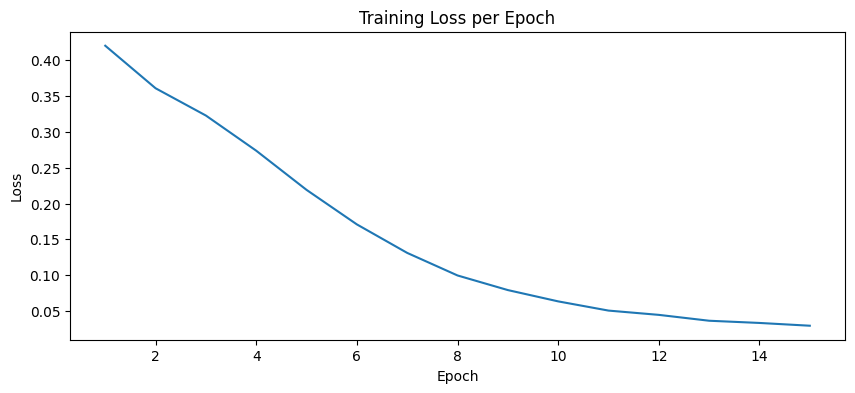

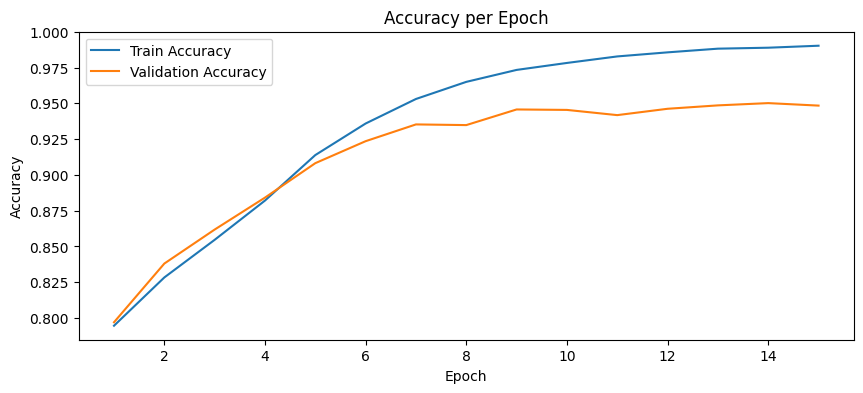

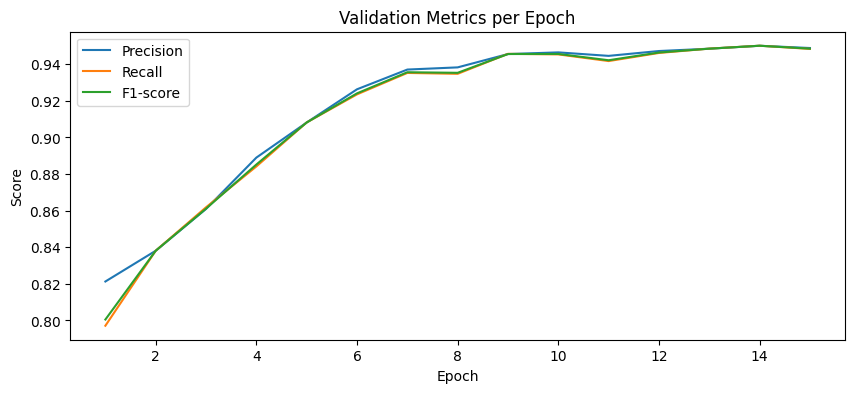

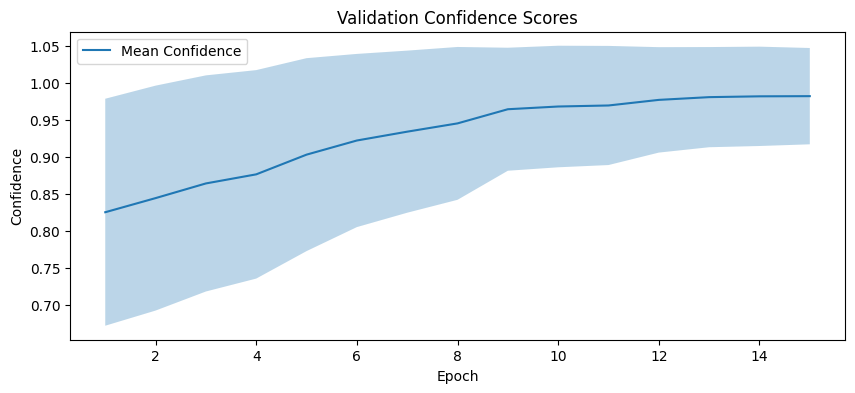

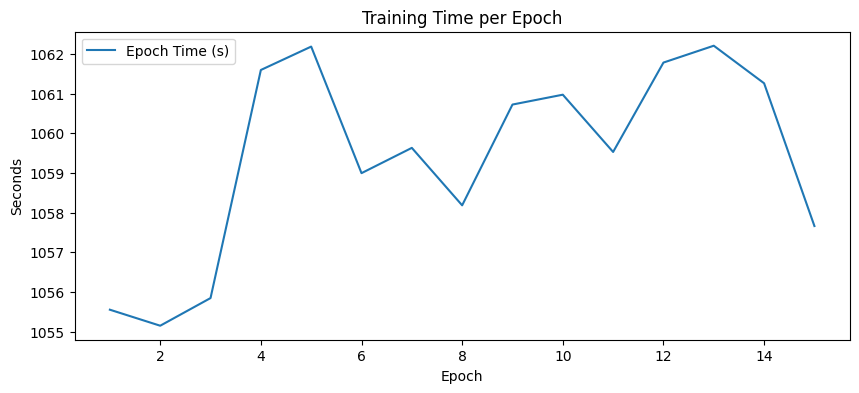

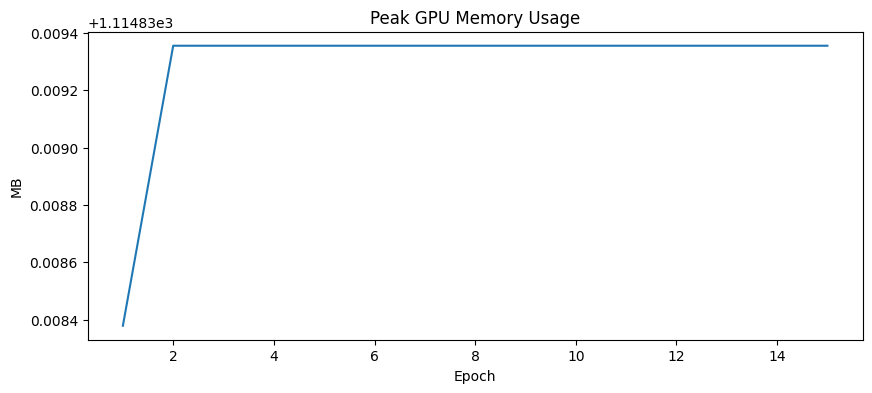


✅ Loaded best model from Epoch 14 for final testing

✅ Model checkpoint saved to: /kaggle/working/models/concat_model_reddit_modified_epochs15_seed42.pth


Testing: 100%|██████████| 2788/2788 [03:24<00:00, 13.65it/s]



================= FINAL TEST RESULTS =================
Dataset: reddit, Seed: 42, Freeze: yes, Epochs: 15
Test Accuracy : 0.9428
Test Precision: 0.9427
Test Recall   : 0.9428
Test F1-score : 0.9426
Test Confidence Mean ± Std: 0.9811 ± 0.0682
Test Time (s) : 204.28
Throughput (samples/sec) : 27.29
Peak GPU Memory (MB) : 946.98

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3513
           1       0.94      0.91      0.92      2062

    accuracy                           0.94      5575
   macro avg       0.94      0.94      0.94      5575
weighted avg       0.94      0.94      0.94      5575


Confusion Matrix:
[[3384  129]
 [ 190 1872]]


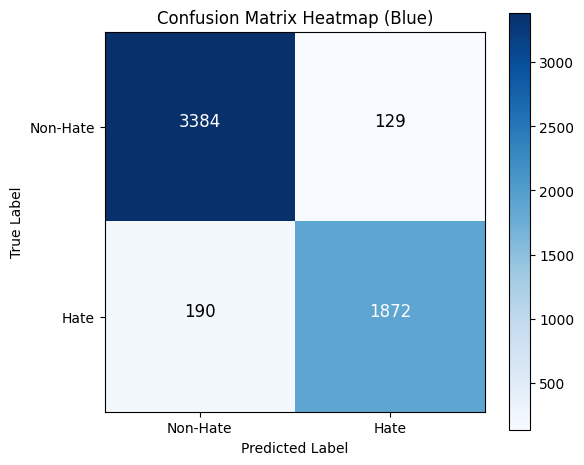

In [3]:
if __name__=="__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_epochs', type=int, default=15)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--dataset', type=str, default='reddit')
    parser.add_argument('--freeze', type=str, choices=['yes','no'], default='yes')
    parser.add_argument('--patience', type=int, default=2, help='Early stopping patience')
    args, unknown = parser.parse_known_args()
    main(args)

In [ ]:
# ===================== LOAD SAVED MODEL =====================
# Specify the path to your saved model
model_path = "/kaggle/working/models/best_concat_model_reddit_seed42.pth"
# Or use the checkpoint path:
# model_path = "/kaggle/working/models/concat_model_reddit_modified_epochs15_seed42.pth"

# Setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Rebuild model architecture (must match training architecture)
hatebert_model = BertModel.from_pretrained("GroNLP/HateBERT").to(device)
additional_model = BertModel.from_pretrained("bert-base-uncased").to(device)

class ProjectionMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ProjectionMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU(),
            nn.Linear(output_size, 2)
        )
    def forward(self, x):
        return self.layers(x)

class GumbelTokenSelector(nn.Module):
    def __init__(self, hidden_size, tau=1.0):
        super().__init__()
        self.tau = tau
        self.proj = nn.Linear(hidden_size * 2, 1)
    def forward(self, token_embeddings, cls_embedding, training=True):
        B, L, H = token_embeddings.size()
        cls_exp = cls_embedding.unsqueeze(1).expand(-1, L, -1)
        x = torch.cat([token_embeddings, cls_exp], dim=-1)
        logits = self.proj(x).squeeze(-1)
        if training:
            probs = F.gumbel_softmax(
                torch.stack([logits, torch.zeros_like(logits)], dim=-1),
                tau=self.tau, hard=False
            )[..., 0]
        else:
            probs = torch.sigmoid(logits)
        return probs, logits

class MultiScaleAttentionCNN(nn.Module):
    def __init__(self, hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4), dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(hidden_size, num_filters, k) for k in kernel_sizes])
        self.attention_fc = nn.Linear(num_filters, 1)
        self.dropout = nn.Dropout(dropout)
        self.out_dim = num_filters * len(kernel_sizes)
    def forward(self, x, mask):
        x = x.transpose(1, 2)
        feats = []
        for conv in self.convs:
            h = F.relu(conv(x))
            h = h.transpose(1, 2)
            attn = self.attention_fc(h).squeeze(-1)
            attn = attn.masked_fill(mask[:, :attn.size(1)] == 0, -1e9)
            alpha = F.softmax(attn, dim=1)
            pooled = torch.sum(h * alpha.unsqueeze(-1), dim=1)
            feats.append(pooled)
        return self.dropout(torch.cat(feats, dim=1))

class TemporalCNN(nn.Module):
    def __init__(self, hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4), dropout=0.1, dilation_base=2):
        super().__init__()
        self.kernel_sizes = kernel_sizes
        self.dilation_base = dilation_base
        self.convs = nn.ModuleList([
            nn.Conv1d(hidden_size, num_filters, k, dilation=dilation_base ** i, padding=0)
            for i, k in enumerate(kernel_sizes)
        ])
        self.dropout = nn.Dropout(dropout)
        self.out_dim = num_filters * len(kernel_sizes)
    def _causal_padding(self, x, kernel_size, dilation):
        padding = (kernel_size - 1) * dilation
        return F.pad(x, (padding, 0))
    def forward(self, x, attention_mask):
        mask = attention_mask.unsqueeze(-1)
        x = x * mask
        x = x.transpose(1, 2)
        feats = []
        for i, conv in enumerate(self.convs):
            kernel_size = self.kernel_sizes[i]
            dilation = self.dilation_base ** i
            x_padded = self._causal_padding(x, kernel_size, dilation)
            c = F.relu(conv(x_padded))
            p = F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2)
            feats.append(p)
        return self.dropout(torch.cat(feats, dim=1))

class ConcatModel(nn.Module):
    def __init__(self, hatebert_model, additional_model, temporal_cnn, msa_cnn, selector, projection_mlp, freeze_additional_model=True, freeze_hatebert=True):
        super().__init__()
        self.hatebert_model = hatebert_model
        self.additional_model = additional_model
        self.temporal_cnn = temporal_cnn
        self.msa_cnn = msa_cnn
        self.selector = selector
        self.projection_mlp = projection_mlp
        if freeze_additional_model:
            for p in self.additional_model.parameters():
                p.requires_grad = False
        if freeze_hatebert:
            for p in self.hatebert_model.parameters():
                p.requires_grad = False

    def forward(self, input_ids, attention_mask, additional_input_ids, additional_attention_mask):
        hate_outputs = self.hatebert_model(input_ids=input_ids, attention_mask=attention_mask)
        seq_emb = hate_outputs.last_hidden_state
        cls_emb = seq_emb[:, 0, :]
        token_probs, token_logits = self.selector(seq_emb, cls_emb, self.training)
        temporal_feat = self.temporal_cnn(seq_emb, attention_mask)
        weights = token_probs.unsqueeze(-1)
        H_r = (seq_emb * weights).sum(dim=1) / (weights.sum(dim=1) + 1e-6)
        with torch.no_grad():
            add_outputs = self.additional_model(input_ids=additional_input_ids, attention_mask=additional_attention_mask)
            add_seq = add_outputs.last_hidden_state
        msa_feat = self.msa_cnn(add_seq, additional_attention_mask)
        concat = torch.cat([cls_emb, temporal_feat, msa_feat, H_r], dim=1)
        return self.projection_mlp(concat)

# Create model components
temporal_cnn = TemporalCNN(hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4)).to(device)
msa_cnn = MultiScaleAttentionCNN(hidden_size=768, num_filters=128, kernel_sizes=(2, 3, 4)).to(device)
selector = GumbelTokenSelector(hidden_size=768, tau=1.0).to(device)
projection_mlp = ProjectionMLP(input_size=temporal_cnn.out_dim + msa_cnn.out_dim + 768 * 2, output_size=512).to(device)

# Create the full model
loaded_model = ConcatModel(
    hatebert_model=hatebert_model,
    additional_model=additional_model,
    temporal_cnn=temporal_cnn,
    msa_cnn=msa_cnn,
    selector=selector,
    projection_mlp=projection_mlp,
    freeze_additional_model=True,
    freeze_hatebert=True
).to(device)

# Load the saved state dict
checkpoint = torch.load(model_path, map_location=device)

# Handle both direct state_dict and checkpoint dict formats
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"Dataset: {checkpoint.get('dataset', 'unknown')}, Seed: {checkpoint.get('seed', 'unknown')}")
else:
    loaded_model.load_state_dict(checkpoint)

loaded_model.eval()
print(f"✅ Model loaded successfully from: {model_path}")


In [ ]:
# ===================== PREDICT WITH LOADED MODEL =====================
# Load tokenizers
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict_sample(text, rationale, model, tokenizer_main, tokenizer_rationale, device, max_length=512):
    """
    Predict hate speech for a single text sample
    
    Args:
        text: Input text to classify
        rationale: Rationale/explanation text (can be empty string if not available)
        model: Loaded model
        tokenizer_main: HateBERT tokenizer
        tokenizer_rationale: BERT tokenizer for rationale
        device: Device to use
        max_length: Max sequence length
    
    Returns:
        prediction: 0 (non-hate) or 1 (hate)
        confidence: Confidence score for the prediction
        probabilities: [prob_non_hate, prob_hate]
    """
    model.eval()
    
    # Tokenize inputs
    encoding = tokenizer_main(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    rationale_encoding = tokenizer_rationale(
        rationale if rationale else text,  # Use text if no rationale
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    add_input_ids = rationale_encoding['input_ids'].to(device)
    add_attention_mask = rationale_encoding['attention_mask'].to(device)
    
    # Inference
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            additional_input_ids=add_input_ids,
            additional_attention_mask=add_attention_mask
        )
        
        probs = torch.softmax(outputs, dim=1)
        prediction = outputs.argmax(dim=1).item()
        confidence = probs[0, prediction].item()
        probabilities = probs[0].cpu().numpy()
    
    return prediction, confidence, probabilities

# Example usage
test_samples = [
    {
        "text": "I love spending time with my friends!",
        "rationale": "This expresses positive emotions about friendship."
    },
    {
        "text": "You people are so annoying and stupid",
        "rationale": "This contains offensive language targeting a group."
    }
]

print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)

for i, sample in enumerate(test_samples, 1):
    text = sample["text"]
    rationale = sample["rationale"]
    
    prediction, confidence, probs = predict_sample(
        text=text,
        rationale=rationale,
        model=loaded_model,
        tokenizer_main=tokenizer,
        tokenizer_rationale=tokenizer_bert,
        device=device
    )
    
    label = "HATE SPEECH" if prediction == 1 else "NON-HATE"
    
    print(f"\nSample {i}:")
    print(f"Text: {text}")
    print(f"Rationale: {rationale}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Probabilities: Non-Hate={probs[0]:.4f}, Hate={probs[1]:.4f}")
    print("-" * 60)